# **Final Exam Project: COVID-19**

*   **name**: Yaqi Zhang
*   **student number**: 1006584288


This project has three goals:

1.   Explore the difference between the symptoms of COVID-19 patients and the symptoms of other common flu.
2.   Study the connection between the common symptoms of COVID-19 patients
3.   Do topic modeling for papers directly related to COVID-19, which is to help gain further insights about COVID-19.  

In [229]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.preprocessing import normalize
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from string import punctuation
import gensim
from gensim import corpora, models
%matplotlib inline
import re, nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
try:
    from gensim.models import word2vec
except:
    !pip install gensim
    from gensim.models import word2vec

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [4]:
from google.colab import drive
drive.mount('/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /drive


# **1. DATA CLEANING**

In [5]:
# load the meta data from the CSV file 
os.chdir('/drive/My Drive/Colab Notebooks/1624 Final')
df=pd.read_csv('metadata.csv')
df.shape

(45774, 17)

In [6]:
# check what features data contain and whether there is any missing value 
df.isna().sum()

cord_uid                           0
sha                            14021
source_x                           0
title                            157
doi                             3334
pmcid                          19531
pubmed_id                      11133
license                            0
abstract                        7861
publish_time                       9
authors                         2000
journal                         4067
Microsoft Academic Paper ID    44810
WHO #Covidence                 44006
has_full_text                      0
full_text_file                 10216
url                              302
dtype: int64

In [0]:
# reload the data with useful features 
df=pd.read_csv('metadata.csv', usecols=['title','abstract','publish_time'])

In [8]:
# drop duplicates
df = df.drop_duplicates(subset='abstract', keep="first")

# drop NANs 
df=df.dropna()

# convert abstracts and titles to lowercase
df["abstract"] = df["abstract"].str.lower()
df["title"] = df["title"].str.lower()

print (df.shape)
df.reset_index(inplace = True,drop = True)

(37525, 3)


In [9]:
# replace the publish data with publish year
df['Year'] = 0
datelist = df['publish_time'].tolist()

for i in range(len(df)):
  date = datelist[i].split('-')
  df['Year'][i] = int(date[0])

df.drop(['publish_time'],axis=1,inplace=True)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [10]:
# Add one more column called "covid19"
# Since covid19 first appeared by the end of 2019, articles published in 2020 with keyword in covid19_count are useful for understanding covid19.
# Tagged those covid19 articles 1, and other biomedical research papers are tagged 0.
df['covid19']=0
covid19 = ['covid','coronavirus', 'ncov','wuhan']
covid19_count = dict((keyword,0) for keyword in covid19)

for keyword in covid19_count:
  for i in range(len(df)):
    if str(keyword) in df['abstract'][i]:
      if df['Year'][i] == 2020:
        df['covid19'][i]=1
print('---------------------------------------------')  
print('The number of articles in each category:')        
Counter(df['covid19'])

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


---------------------------------------------
The number of articles in each category:


Counter({0: 35505, 1: 2020})

In [11]:
# show 5 lines of the new dataframe
df.head()

,title,abstract,Year,covid19
0,siann: strain identification by alignment to n...,next-generation sequencing is increasingly bei...,2014,0
1,spatial epidemiology of networked metapopulati...,an emerging disease is one infectious epidemic...,2014,0
2,sequencing of the human ig light chain loci fr...,germline variation at immunoglobulin gene (ig)...,2014,0
3,bayesian mixture analysis for metagenomic comm...,deep sequencing of clinical samples is now an ...,2014,0
4,mapping a viral phylogeny onto outbreak trees ...,developing methods to reconstruct transmission...,2014,0


# **2. Data Visualization and Exploratory Data Analysis**

### **2.1 Distribution of publish year**

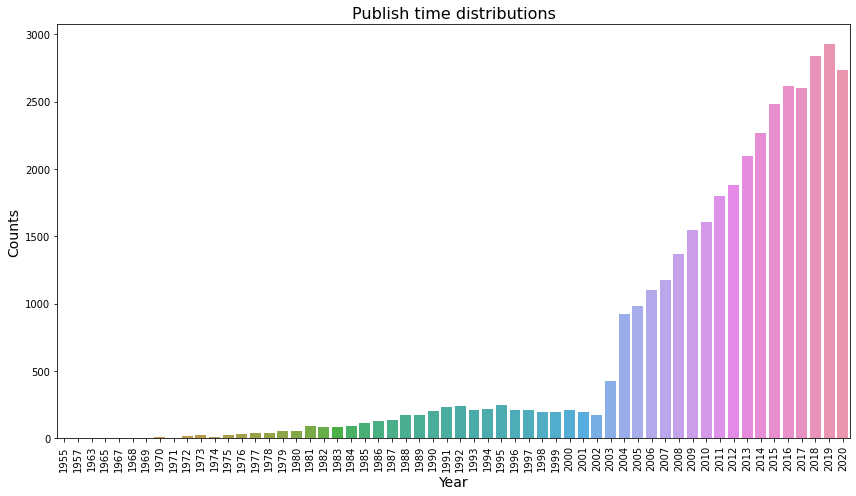

In [12]:
# plot the distribution of publish year
plt.figure(figsize=(12,7))
year_dis = sns.countplot(x='Year',data=df)
year_dis.set_xticklabels(year_dis.get_xticklabels(), rotation=90)
year_dis.axes.set_title('Publish time distributions',fontsize=16)
year_dis.set_xlabel('Year',fontsize=14)
year_dis.set_ylabel('Counts',fontsize=14)
plt.tight_layout()
plt.show()

The publish time ranges from 1955 to 2020. There is a significant increase of article number after 2003, showing that more research is being done on influenza in recent years.

### **2.2 Words Frequency**

In [0]:
# To see the difference between covid19 and other kinds of flu, seperate the dataframe into two parts.
covid19 = df.groupby(by=['covid19']).get_group(1)
others = df.groupby(by=['covid19']).get_group(0)
covid19.reset_index(inplace = True,drop = True)
others.reset_index(inplace = True,drop = True)

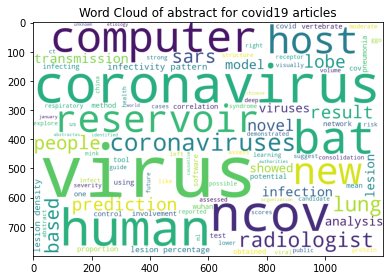

In [14]:
# Create the word cloud of abstract for covid19 articles to see the most frequently appearing words
stop=set(stopwords.words('english'))
wc = WordCloud(stopwords=stop, max_words=100, background_color='white', width=1200, height=800)
plt.imshow(wc.generate(str(covid19['abstract'].values)))
plt.title('Word Cloud of abstract for covid19 articles')
plt.tight_layout()  

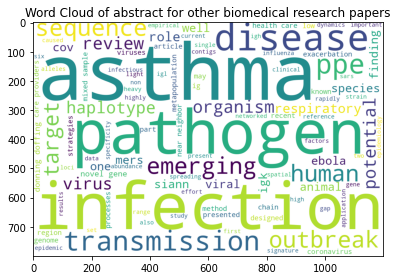

In [15]:
# Create the word cloud of abstract for articles of other influenza
plt.imshow(wc.generate(str(others['abstract'].values)))
plt.title('Word Cloud of abstract for other biomedical research papers')
plt.tight_layout()  

The two word clouds above clearly show the difference between covid19 and other kinds of flu. Words like 'asthma', 'pathogen' are frequntly used in articles of other kinds of flu while covid19 is characterized by words like 'bat', 'lung', 'coronavirus'.

### **2.3 Differences in symptoms**

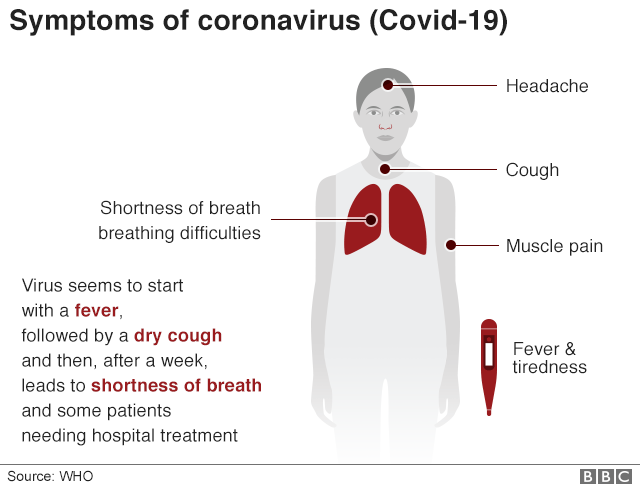

In [308]:
from IPython.display import Image
os.chdir('/drive/My Drive/Colab Notebooks/1624 Final')
Image(filename='symptoms.png')

In [0]:
# Set a symptoms list based on common influenza symptoms
symptoms = ['headache','sore throat','cough','cold','fever','pneumonia','bronchitis','fatigue','diarrhea']

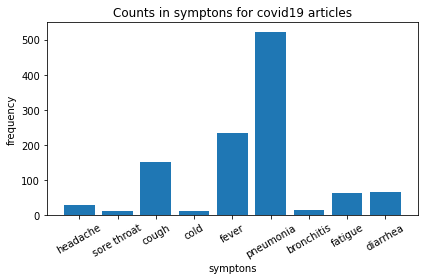

In [152]:
# Count frequency of each symptoms on articles tagged 'covid19'
symptom_count = dict((symptom,0) for symptom in symptoms)
for symptom in symptom_count:
    for abstract in covid19['abstract']:
        if str(symptom) in abstract:
            symptom_count[symptom] += 1

plt.bar(symptom_count.keys(),symptom_count.values())
plt.xticks(rotation=30)
plt.xlabel('symptoms')
plt.ylabel('frequency')
plt.title('Counts in symptoms for covid19 articles')
plt.tight_layout()


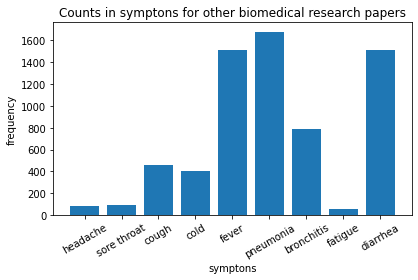

In [151]:
# Count frequency of each symptoms on articles related to other flu
symptom_count = dict((symptom,0) for symptom in symptoms)
for symptom in symptom_count:
    for abstract in others['abstract']:
        if str(symptom) in abstract:
            symptom_count[symptom] += 1

plt.bar(symptom_count.keys(),symptom_count.values())
plt.xticks(rotation=30)
plt.xlabel('symptoms')
plt.ylabel('frequency')
plt.title('Counts in symptoms for other biomedical research papers')
plt.tight_layout()


Patients with covid19 have some symptoms similar to other flu patients. 
Compared to pneumonia and fever, other symptoms are not that common among covod19 patients, which shows that covid19 virus tends to infect the lower respiratory tract in humans and cause fever.
And it is worth mentioning that pneumonia and fever are very distinctive features of covid19.

# **3. Model selection and fitting to data**

In this part, we'll further explore papers related to covid-19 in order to assist in the fight against the covid-19 pandemic. In Section 3.1, we will explore relationships of various symptoms on covid-19 and other flu separately, then compare their difference. In Section 3.2, we're going to do topic modeling for papers related to covid-19 (tagged 1 on 'covid19' feature).   

### **3.1 Explore the connection of symptoms**

In [0]:
def cumulative_dist(symptom1, symptom2, df):
    cum_sum = 0
    number_of_papers = 0
    if symptom1 == symptom2: return 0
    
    for abstract in df['abstract']:
        if ((symptom1 in abstract) and (symptom2 in abstract)):
            number_of_papers += 1
            cum_sum -= 1
        elif (((symptom1 in abstract) and (symptom2 not in abstract)) or ((symptom1 not in abstract) and (symptom2 in abstract))):
            number_of_papers += 1
            cum_sum += 1
    
    return cum_sum/number_of_papers

#Populate Matrix of symptom distances by mining the text of the papers found in the database and using the distance rule as
#For a symptom A and B mentioned in a paper together the distanceA_B += 1 
#or distanceA_B -= 1 if they are not mentioned together

In [137]:
# For articles related to covid-19
symptom_dist_1 = np.zeros((len(symptoms),len(symptoms)), dtype=float)
df_symptoms_1 = pd.DataFrame(symptom_dist_1, columns=symptoms, index=symptoms)

for i in range(len(symptoms)):
    for j in range(len(symptoms)):
         symptom_dist_1[i][j] = cumulative_dist(symptoms[i],symptoms[j], covid19)  

i = 0
for symptom in symptoms:
    df_symptoms_1[symptom] = np.power(symptom_dist_1[i],9)
    i += 1
print('Our distance matrix looks like this:')   
df_symptoms_1

Our distance matrix looks like this:


,headache,sore throat,cough,cold,fever,pneumonia,bronchitis,fatigue,diarrhea
headache,0.000000,9.009007e-07,4.197084e-15,1.000000,2.127233e-09,9.500087e-03,1.000000,9.914500e-24,7.014260e-16
sore throat,0.212960,0.000000e+00,3.459147e-06,0.000869,1.623237e-04,5.958205e-02,1.000000,4.568676e-06,8.257151e-05
cough,0.025267,2.472970e-01,0.000000e+00,1.000000,-2.481755e-68,2.216179e-11,0.047938,3.954090e-45,5.452655e-15
cold,1.000000,4.569861e-01,1.000000e+00,0.000000,5.176064e-01,2.143875e-01,0.001529,1.000000e+00,1.000000e+00
fever,0.108749,3.792550e-01,-3.078269e-08,0.929442,0.000000e+00,1.051107e-16,0.266474,1.577741e-24,6.273089e-12
pneumonia,0.596078,7.309736e-01,6.549050e-02,0.842731,1.677364e-02,0.000000e+00,0.544502,1.697246e-05,1.029513e-03
bronchitis,1.000000,1.000000e+00,7.135237e-01,0.486565,8.633440e-01,9.346880e-01,0.000000,1.000000e+00,1.000000e+00
fatigue,0.002780,2.550606e-01,1.165034e-05,1.000000,2.266404e-03,2.951017e-01,1.000000,0.000000e+00,1.940585e-12
diarrhea,0.020712,3.518151e-01,2.601229e-02,1.000000,5.692142e-02,4.656613e-01,1.000000,4.996423e-02,0.000000e+00


In [138]:
# For other biomedical research papers
symptom_dist_0 = np.zeros((len(symptoms),len(symptoms)), dtype=float)
df_symptoms_0 = pd.DataFrame(symptom_dist_0, columns=symptoms, index=symptoms)

for i in range(len(symptoms)):
    for j in range(len(symptoms)):
         symptom_dist_0[i][j] = cumulative_dist(symptoms[i],symptoms[j], others)  

i = 0
for symptom in symptoms:
    df_symptoms_0[symptom] = np.power(symptom_dist_0[i],9)
    i += 1
print('Our distance matrix looks like this:')   
df_symptoms_0

Our distance matrix looks like this:


,headache,sore throat,cough,cold,fever,pneumonia,bronchitis,fatigue,diarrhea
headache,0.000000,5.233785e-07,5.215876e-05,0.128639,3.470014e-03,0.326545,0.688773,1.011239e-07,0.234096
sore throat,0.200489,0.000000e+00,1.253023e-09,0.033722,3.630985e-03,0.186595,0.832381,2.471955e-03,0.441686
cough,0.334309,1.025379e-01,0.000000e+00,0.004418,1.870578e-10,0.000008,0.022235,1.800056e-02,0.131562
cold,0.796236,6.861740e-01,5.474658e-01,0.000000,6.679877e-02,0.030752,0.081471,7.015337e-01,0.357901
fever,0.532971,5.356629e-01,8.300579e-02,0.740319,0.000000e+00,0.000010,0.343645,1.332110e-01,0.009568
pneumonia,0.883067,8.298294e-01,2.713000e-01,0.679182,2.790520e-01,0.000000,0.017288,4.703063e-01,0.081054
bronchitis,0.959419,9.798213e-01,6.551464e-01,0.756833,8.880892e-01,0.637081,0.000000,1.000000e+00,0.276289
fatigue,0.167017,5.132605e-01,6.399454e-01,0.961378,7.993310e-01,0.919598,1.000000,0.000000e+00,0.731880
diarrhea,0.851006,9.132047e-01,7.982257e-01,0.892109,5.965532e-01,0.756402,0.866821,9.659124e-01,0.000000


#### **Model 1: Hierarchical Clustering**

In [0]:
# Magnify the distance prior to HCA
distance_1 = np.power(symptom_dist_1,3)
distance_0 = np.power(symptom_dist_0,3)   

# HCA
HCA_1 = sch.linkage(distance_1, method='centroid')
HCA_0 = sch.linkage(distance_0, method='centroid')

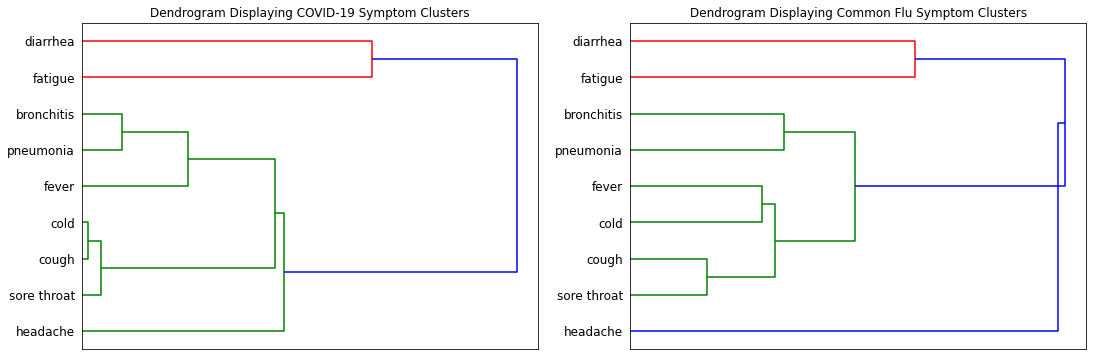

In [178]:
# Get dendrograms
plt.figure(figsize=(18,6))

ax1 = plt.subplot(1, 2, 1)
Z1 = sch.dendrogram(HCA_1, orientation='right')
ax1.set_xticks([])
ax1.set_yticklabels(symptoms)
ax1.set_title("Dendrogram Displaying COVID-19 Symptom Clusters")

ax0 = plt.subplot(1, 2, 2)
Z0 = sch.dendrogram(HCA_0, orientation='right')
ax0.set_xticks([])
ax0.set_yticklabels(symptoms)
ax0.set_title("Dendrogram Displaying Common Flu Symptom Clusters")

plt.show()

#### **Model 2: K-means** 

In [0]:
kmeans = KMeans(n_clusters=4, verbose=10, n_jobs=2)
kmeans_1 = kmeans.fit_predict(distance_1)
kmeans_0 = kmeans.fit_predict(distance_0)

In [179]:
df_symptoms_1['kmeans'] = kmeans_1
result1 = df_symptoms_1['kmeans'].sort_values(ascending=True)

df_symptoms_0['kmeans'] = kmeans_0
result0 = df_symptoms_0['kmeans'].sort_values(ascending=True)

print('Kmeans clustering result for covid19 symptoms:\n', result1)
print('------------------------------------------------------------------------')
print('Kmeans clustering result for common flu symptoms:\n',result0)

Kmeans clustering result for covid19 symptoms:
 cold           0
cough          1
fever          1
pneumonia      1
headache       2
sore throat    2
fatigue        2
diarrhea       2
bronchitis     3
Name: kmeans, dtype: int32
------------------------------------------------------------------------
Kmeans clustering result for common flu symptoms:
 headache       0
sore throat    0
cough          0
fever          0
bronchitis     1
diarrhea       1
fatigue        2
cold           3
pneumonia      3
Name: kmeans, dtype: int32


Compared these two models, there are differences in the clustering results.

The advantages of hierarchical clustering are that there is no need to specify the number of types in advance and it shows the hierarchical relationship of each cluster. However, the computational complexity is higher.

K-means is computationally faster and easy to implement than hierarchical clustering, but k has to be chosen manually in advance.

### **3.2 Topic Modeling**

Topic modeling is a useful technique to extract the hidden topics from huge amount of text. Latent Dirichlet Allocation (LDA) is an example of topic model and is used to classify text in a document to a particular topic.

In [264]:
# Use LDA to do topic modeling based on words appeared in the titles of all covid19 papers
for i in range(len(covid19)):
  t = covid19['title'][i]
  t = t.lower()
  #stop words
  stopwordslist = stopwords.words('english') + list(punctuation)
  tokenizer = RegexpTokenizer(r'\w+')         
  b = tokenizer.tokenize(t)
  t = [word for word in b if word not in stopwords.words('english')]
  # stem
  ss = SnowballStemmer('english')
  t = [ps.stem(word) for word in t] 
  covid19['title'][i] = t

#show 10 lines of processed title data
covid19[['title']].head(10)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exec(code_obj, self.user_global_ns, self.user_ns)


,title
0,"[mathemat, model, simul, transmiss, wuhan, nov..."
1,"[genom, protein, structur, model, analysi, dep..."
2,"[host, infect, predict, wuhan, 2019, novel, co..."
3,"[novel, ionophor, activ, la, cross, viru, iden..."
4,"[discoveri, novel, coronaviru, associ, recent,..."
5,"[function, assess, cell, entri, receptor, usag..."
6,"[novel, coronaviru, 2019, ncov, earli, estim, ..."
7,"[preliminari, estim, basic, reproduct, number,..."
8,"[model, epidem, trend, 2019, novel, coronaviru..."
9,"[pattern, earli, human, human, transmiss, wuha..."


In [0]:
#For each topic, we will explore the words occuring in that topic and its relative weight.
doc_clean = [doc for doc in covid19['title']]
dictionary = corpora.Dictionary(doc_clean)
corpus = [dictionary.doc2bow(doc) for doc in doc_clean]
corpus_tfidf = models.TfidfModel(corpus)[corpus]

lda = gensim.models.LdaModel
ldamodel = lda(corpus_tfidf, num_topics=5, id2word = dictionary)

In [305]:
ldamodel.show_topics(num_topics=5, num_words=30)

[(0,
  '0.031*"respons" + 0.027*"milan" + 0.026*"initi" + 0.023*"mass" + 0.021*"gather" + 0.017*"itali" + 0.015*"system" + 0.015*"decemb" + 0.015*"interim" + 0.014*"31" + 0.014*"medic" + 0.014*"4" + 0.014*"stage" + 0.014*"outbreak" + 0.014*"psycholog" + 0.013*"guidanc" + 0.012*"emerg" + 0.012*"popul" + 0.012*"gener" + 0.012*"among" + 0.012*"factor" + 0.011*"enhanc" + 0.011*"state" + 0.011*"unit" + 0.011*"2019" + 0.011*"februari" + 0.010*"19" + 0.010*"covid" + 0.010*"associ" + 0.009*"public"'),
 (1,
  '0.042*"korea" + 0.041*"isol" + 0.023*"patient" + 0.023*"futur" + 0.022*"prioriti" + 0.022*"identif" + 0.019*"insight" + 0.019*"first" + 0.018*"ongo" + 0.017*"ncov" + 0.017*"2019" + 0.016*"infecti" + 0.015*"viru" + 0.014*"research" + 0.014*"emerg" + 0.013*"global" + 0.012*"coronaviru" + 0.012*"novel" + 0.011*"public" + 0.011*"epidem" + 0.011*"pneumonia" + 0.011*"2" + 0.010*"sar" + 0.010*"epidemiolog" + 0.010*"cov" + 0.010*"health" + 0.010*"control" + 0.010*"diseas" + 0.009*"outbreak" + 0.0

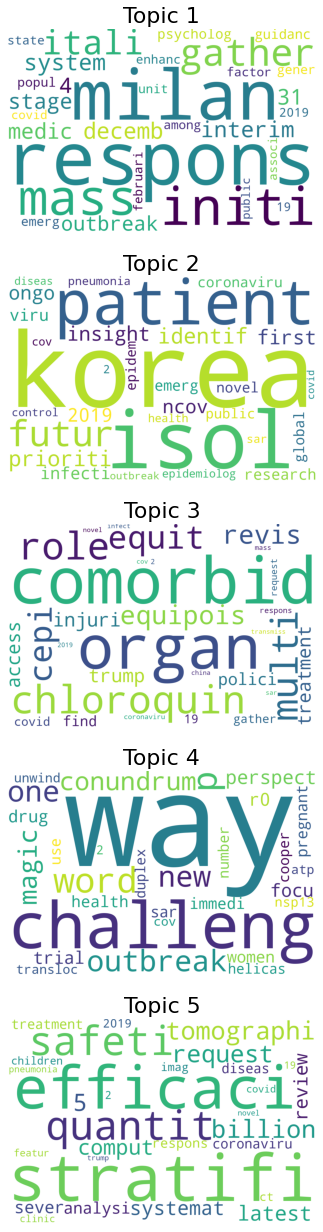

In [306]:
# To display the topic clearly, show the word cloud of each topics
fig, axes = plt.subplots(5, 1, figsize=(15,22), sharex=True, sharey=True)
topics = ldamodel.show_topics(formatted=False, num_words=30)
for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    wc.generate_from_frequencies(topic_words, max_font_size=500)
    plt.gca().imshow(wc)
    plt.gca().set_title('Topic ' + str(i + 1), fontdict=dict(size=22))
    plt.gca().axis('off')


Observing the word clouds above, papers related to covid 19 are roughly divided into 5 topics. For example, topic 1 focus on the outbreak of covid19 in Milan, which should make governments learn a lesson and pay more attention to the prevention of covid19. And topic 3 is about the research on drugs such as chloroquine, whether these drugs have some side effects and cause damage to certain organs? 
These topics provide some reference directions for further research. 

## **4. Deriving insights about policy and guidance to tackle the outbreak based on model findings**


Based on the dendrograms displayed in Model 1: Hierarchical Clustering, symptoms of both covid19 and common flu can be divided into four clusters.


*   covid19: [diarrhea, fatigue]; [fever, pneumonia, bronchitis]; [cold, cough , sore throat]; [headache]
*   common flu: [diarrhea, fatigue]; [pneumonia, bronchitis]; [fever, cold, cough, sore throat]; [headache]


The two clustering results are somewhat similar. For both covid19 and common flu, diarrhea and fatigue are relatively rare and have less connection to other symptoms. 

The biggest difference between these two is the connection between fever and other symptoms.
For covid19, fever has more connection with pneumonia and bronchitis. For other common flu, fever, cold, cough and sore throat are considered into one cluster. This difference shows that it may be a common flu when fever, cold, cough and sore throat appear at the same time, while a patient with pneumonia having symptoms of fever is most likely an infected person with COVID-19.

Therefore for further prevention of COVID-19, people should pay attention to these symptoms. 
When fever appears at the same time as pneumonia, self isolate immediately and contact local public health unit.

COVID-19 virus spreads by respiratory droplets of an infected person to others with whom they have close contact. So once these respiratory symptoms appear, the suspected infection should avoid using public transportation and wear a mask when they have to go out.


